In [15]:
import warnings
warnings.filterwarnings(action='ignore')

import sys
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from tabulate import tabulate

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import t, f
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

In [2]:
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.unicode_minus"] = False

In [3]:
df = pd.read_excel("./data/fish.xlsx")
df.head()

,길이,높이,두께,무게
0,8.4,2.11,1.41,5.9
1,13.7,3.53,2.00,32.0
2,15.0,3.82,2.43,40.0
3,16.2,4.59,2.63,51.5
4,17.4,4.59,2.94,70.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   길이      56 non-null     float64
 1   높이      56 non-null     float64
 2   두께      56 non-null     float64
 3   무게      56 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB


In [5]:
yname = '무게'
x = df.drop(yname, axis = 1)
y = df[yname]

In [6]:
xnames = list(x.columns)
xnames

['길이', '높이', '두께']

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [8]:
model = LinearRegression()

In [9]:
model.fit(x_train, y_train)

LinearRegression()

In [10]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
print(y_train_pred.shape, y_test_pred.shape)

(39,) (17,)


In [11]:
target = [[x_train, y_train, y_train_pred], [x_test, y_test, y_test_pred]]

[훈련결과 시각화]


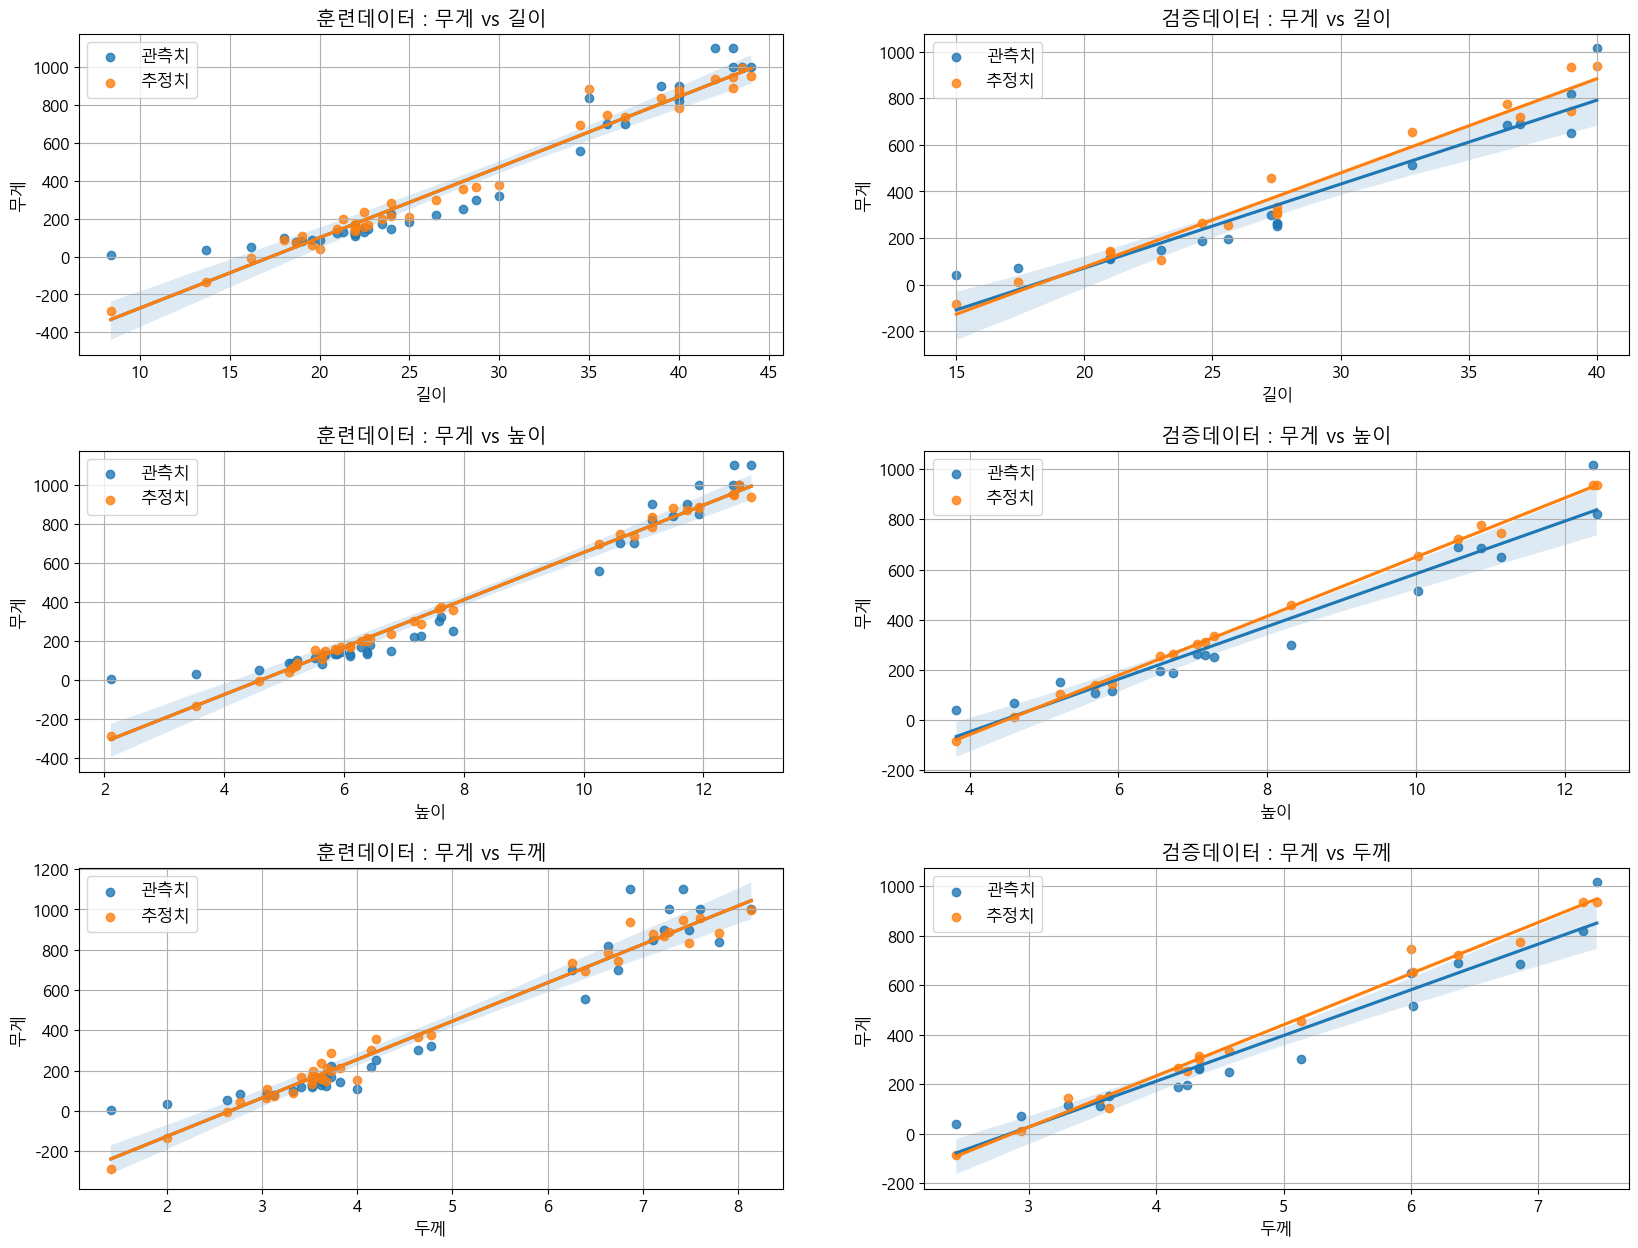

[성능지표]
+-------------------------------+--------------+--------------+
|                               |   훈련데이터 |   검증데이터 |
|-------------------------------+--------------+--------------|
| 결졍계수(R2)                  |     0.947601 |     0.910954 |
| 평균절대오차(MAE)             |      62.1805 |      76.6279 |
| 평균제곱오차(MSE)             |      7038.54 |      7357.52 |
| 평균오차(RMSE)                |       83.896 |       85.776 |
| 평균 절대 백분오차 비율(MAPE) |      164.318 |      44.1894 |
| 평균 비율 오차(MPE)           |      133.143 |      6.83553 |
+-------------------------------+--------------+--------------+



In [12]:
result_data = []

print("[훈련결과 시각화]")
size = len(xnames)

fig, ax = plt.subplots(len(xnames), 2, figsize = (20, 5 * size))
fig.subplots_adjust(hspace = 0.3)

for i, v in enumerate(target):
    result = {
        "결졍계수(R2)" : r2_score(v[1], v[2]),
        "평균절대오차(MAE)" : mean_absolute_error(v[1], v[2]),
        "평균제곱오차(MSE)" : mean_squared_error(v[1], v[2]),
        "평균오차(RMSE)" : np.sqrt(mean_squared_error(v[1], v[2])),
        "평균 절대 백분오차 비율(MAPE)" : np.mean(np.abs((v[1] - v[2]) / v[1]) * 100),
        "평균 비율 오차(MPE)" : np.mean((v[1] - v[2])/ v[1] * 100)
    }

    result_data.append(result)

    for j, w in enumerate(xnames):
        sns.regplot(x = v[0][w], y = v[1], ci = 95, ax = ax[j][i], label = '관측치')
        sns.regplot(x = v[0][w], y = v[2], ci = 0, ax = ax[j][i], label = '추정치')
        ax[j][i].set_title(f"훈련데이터 : {yname} vs {w}" if i == 0 else f"검증데이터 : {yname} vs {w}")
        ax[j][i].legend()
        ax[j][i].grid(True)

plt.show()
plt.close()

result_df = pd.DataFrame(result_data, index = ["훈련데이터", "검증데이터"])
print("[성능지표]")
print(tabulate(result_df.T, headers = 'keys', tablefmt = 'psql', showindex = True, numalign = "right"), end = "\n\n")

In [13]:
expr = "{yname} = ".format(yname = yname)

for i, v in enumerate(xnames):
    expr += "%0.3f * %s + " % (model.coef_[i], v)

expr += "%0.3f" % model.intercept_
print("[회귀식]")
print(expr)

[회귀식]
무게 = -0.117 * 길이 + 84.525 * 높이 + 60.034 * 두께 + -551.617


In [14]:
for i, v in enumerate(target):
    print("[훈련데이터에" if i == 0 else "[검증데이터에", "대한 결과보고]")

    target_x = v[0]
    target_y = v[1]
    target_y_pred = v[2]

    resid = target_y - target_y_pred

    params = np.append(model.intercept_, model.coef_)

    design_x = target_x.copy()
    design_x.insert(0, '상수', 1)

    dot = np.dot(design_x.T, design_x)
    inv = np.linalg.inv(dot)
    dia = inv.diagonal()

    MSE = (sum(target_y - target_y_pred) ** 2) / (len(design_x) - len(design_x.iloc[0]))

    se_b = np.sqrt(MSE * dia)
    ts_b = params / se_b

    p_values = [2 * (1 - t.cdf(np.abs(i), (len(design_x) - len(design_x.iloc[0])))) for i in ts_b]

    vif = [variance_inflation_factor(target_x, list(target_x.columns).index(v)) for i, v in enumerate(target_x.columns)]

    train_df = target_x.copy()
    train_df[target_y.name] = target_y
    scaler = StandardScaler()
    std = scaler.fit_transform(train_df)
    std_df = pd.DataFrame(std, columns=train_df.columns)
    std_x = std_df[xnames]
    std_y = std_df[yname]
    std_model = LinearRegression()
    std_fit = std_model.fit(std_x, std_y)
    beta = std_fit.coef_

    result_df = pd.DataFrame({
        "종속변수": [yname] * len(xnames),
        "독립변수": xnames,
        "B(비표준화 계수)": np.round(params[1:], 4),
        "표준오차": np.round(se_b[1:], 3),
        "β(표준화 계수)": np.round(beta, 3),
        "t": np.round(ts_b[1:], 3),
        "유의확률": np.round(p_values[1:], 3),
        "VIF": vif,
    })

    print(tabulate(result_df, headers='keys', tablefmt='psql', showindex=True), end="\n\n")

    resid = target_y - target_y_pred        # 잔차
    dw = durbin_watson(resid)               # 더빈 왓슨 통계량
    r2 = r2_score(target_y, target_y_pred)  # 결정계수(설명력)
    rowcount = len(target_x)                # 표본수
    featurecount = len(target_x.columns)    # 독립변수의 수

    # 보정된 결정계수
    adj_r2 = 1 - (1 - r2) * (rowcount-1) / (rowcount-featurecount-1)

    # f값
    f_statistic = (r2 / featurecount) / ((1 - r2) / (rowcount - featurecount - 1))

    # Prob (F-statistic)
    p = 1 - f.cdf(f_statistic, featurecount, rowcount - featurecount - 1)

    tpl = "𝑅^2(%.3f), Adj.𝑅^2(%.3f), F(%.3f), P-value(%.4g), Durbin-Watson(%.3f)"
    print(tpl % (r2, adj_r2, f_statistic, p, dw), end="\n\n")

    # 결과보고
    tpl = "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s) = %0.3f, p %s 0.05)."

    print(tpl % (
        yname,
        ",".join(xnames),
        "유의하다" if p <= 0.05 else "유의하지 않다",
        len(target_x.columns),
        len(target_x.index)-len(target_x.columns)-1,
        f_statistic,
        "<=" if p <= 0.05 else ">"), end="\n\n")

    # 독립변수 보고
    for n in xnames:
        item = result_df[result_df['독립변수'] == n]
        coef = item['B(비표준화 계수)'].values[0]
        pvalue = item['유의확률'].values[0]

        s = "%s의 회귀계수는 %0.3f(p %s 0.05)로, %s에 대하여 %s."
        k = s % (n,
                coef,
                "<=" if pvalue <= 0.05 else '>',
                yname,
                '유의미한 예측변인인 것으로 나타났다' if pvalue <= 0.05 else '유의하지 않은 예측변인인 것으로 나타났다'
        )

        print(k)

    print("")    

[훈련데이터에 대한 결과보고]
+----+------------+------------+--------------------+------------+------------------+--------------+------------+---------+
|    | 종속변수   | 독립변수   |   B(비표준화 계수) |   표준오차 |   β(표준화 계수) |            t |   유의확률 |     VIF |
|----+------------+------------+--------------------+------------+------------------+--------------+------------+---------|
|  0 | 무게       | 길이       |            -0.1167 |          0 |           -0.003 | -5.32592e+13 |          0 | 287.919 |
|  1 | 무게       | 높이       |            84.5254 |          0 |            0.676 |  1.00402e+16 |          0 | 488.5   |
|  2 | 무게       | 두께       |            60.0344 |          0 |            0.304 |  6.66551e+15 |          0 | 208.607 |
+----+------------+------------+--------------------+------------+------------------+--------------+------------+---------+

𝑅^2(0.948), Adj.𝑅^2(0.943), F(210.986), P-value(1.11e-16), Durbin-Watson(1.855)

무게에 대하여 길이,높이,두께로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(3,35) = 210.98